## Predicting Damage with Logistic Regression

In [8]:
import sqlite3

import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
from category_encoders import  OneHotEncoder
from sklearn.linear_model import  LogisticRegression
from sklearn.metrics import  accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

#### Prepare Data

Import

1. Using a function to import from an sqlite database

In [9]:
def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
        SELECT distinct(i.building_id) AS b_id,
           s.*,
           d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 4
    """

    # Read query results into DataFrame
    df = pd.read_sql(query, conn, "b_id")

    
    return df

In [ ]:
df = wrangle("/home/jovyan/nepal.sqlite")
df.head()

2. Importing csv file as pd DataFrame

In [36]:
df = pd.read_csv("data/df.csv").set_index("b_id")
df.head()

,building_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,condition_post_eq,superstructure,damage_grade
b_id,,,,,,,,,,,,,,,,,
164002,164002,3,3,20,560,18,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Repaired and used,Stone,Grade 2
164081,164081,2,2,21,200,12,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,Stone,Grade 2
164089,164089,3,3,18,315,20,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,Stone,Grade 2
164098,164098,2,2,45,290,13,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,Stone,Grade 3
164103,164103,2,2,21,230,13,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,Stone,Grade 3


Drop Features from the df (Drop Leaky features)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70836 entries, 164002 to 234835
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   building_id             70836 non-null  int64 
 1   count_floors_pre_eq     70836 non-null  int64 
 2   count_floors_post_eq    70836 non-null  int64 
 3   age_building            70836 non-null  int64 
 4   plinth_area_sq_ft       70836 non-null  int64 
 5   height_ft_pre_eq        70836 non-null  int64 
 6   height_ft_post_eq       70836 non-null  int64 
 7   land_surface_condition  70836 non-null  object
 8   foundation_type         70836 non-null  object
 9   roof_type               70836 non-null  object
 10  ground_floor_type       70836 non-null  object
 11  other_floor_type        70836 non-null  object
 12  position                70836 non-null  object
 13  plan_configuration      70836 non-null  object
 14  condition_post_eq       70836 non-null  object
 15  s

Remove features that will give the model info whether the building suffered earthquake damage:

In [38]:
# The 3 columns with post-earthquake info
for col in df.columns:
    if "post_eq" in col:
        print(col)

count_floors_post_eq
height_ft_post_eq
condition_post_eq


In [39]:
# The 3 columns with post-earthquake info
drop_cols =[col for col in df.columns if "post_eq" in col]
drop_cols


['count_floors_post_eq', 'height_ft_post_eq', 'condition_post_eq']

In [40]:
df.drop(columns=drop_cols, inplace=True)
df.head()

,building_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,damage_grade
b_id,,,,,,,,,,,,,,
164002,164002,3,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,Grade 2
164081,164081,2,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,Grade 2
164089,164089,3,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,Grade 2
164098,164098,2,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,Grade 3
164103,164103,2,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,Grade 3


In [41]:
# Assert column drops
assert (
    df.filter(regex="post_eq").shape[1] == 0
), "`df` still has leaky features. Try again!"

Binary Classification Feature: ```severe_damage```

- For buildings where the ```damage_grade``` is Grade 4 or above, ```severe_damage``` is 1, and 0 for all other categories. 
- Next step is to drop the ```damage_grade``` column to avoid leakage.

In [42]:
df["damage_grade"].value_counts()

damage_grade
Grade 5    24869
Grade 4    20650
Grade 3    14097
Grade 2     7650
Grade 1     3570
Name: count, dtype: int64

In [45]:
df["damage_grade"]=df["damage_grade"].str[-1].astype(int)

In [48]:
print(df["damage_grade"].value_counts())

damage_grade
5    24869
4    20650
3    14097
2     7650
1     3570
Name: count, dtype: int64


In [55]:
df["severe_damage"]=(df["damage_grade"] > 3).astype(int)

In [60]:
df.drop(columns="damage_grade", inplace=True)

In [61]:
df.head()

,building_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,,,
164002,164002,3,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,0
164081,164081,2,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,0
164089,164089,3,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,0
164098,164098,2,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,0
164103,164103,2,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Stone,0


Assert column

In [62]:
print(df["severe_damage"].value_counts())

severe_damage
1    45519
0    25317
Name: count, dtype: int64


In [63]:
assert (
    "damage_grade" not in df.columns
), "Your DataFrame should not include the `'damage_grade'` column."
assert (
    "severe_damage" in df.columns
), "Your DataFrame is missing the `'severe_damage'` column."
assert (
    df["severe_damage"].value_counts().shape[0] == 2
), f"The `'damage_grade'` column should have only two unique values, not {df['severe_damage'].value_counts().shape[0]}"

##### Explore

Correlation Heatmap

In [68]:
correlation = df.select_dtypes("number").drop(columns="severe_damage").corr().round(4)
correlation

,building_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq
building_id,1.0000,-0.0327,0.0095,0.0901,0.0171
count_floors_pre_eq,-0.0327,1.0000,0.0632,0.1984,0.7401
age_building,0.0095,0.0632,1.0000,-0.0169,0.0477
plinth_area_sq_ft,0.0901,0.1984,-0.0169,1.0000,0.2835
height_ft_pre_eq,0.0171,0.7401,0.0477,0.2835,1.0000


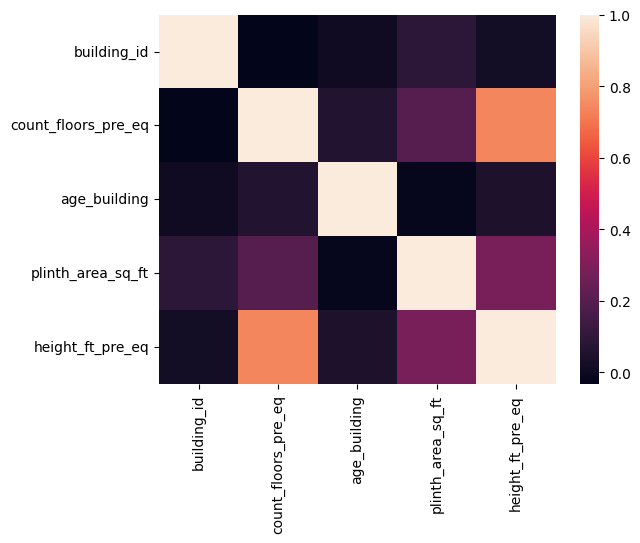

In [70]:
sns.heatmap(correlation);